Let's set up a Pavolovian conditioning experiment.

Agent A

Sensory input
* Vision: 10 bit vector. A specific sparse pattern indicates sight of food.
* Taste: 10 bit vector. A specific sparse pattern indicates taste of food.

Among uncorrelated sensory activity, the following pattern is hidden.

* Taste of food -- time delay t1 --> reward

Would this agent associate high reward prediction for Taste of food?

Later, the following pattern is presented.

* Sight of food --- time delay t0 --> Taste of food --- time delay t1 --> reward

Would the agent now associate high reward prediction for Sight of food? Will it stop associating Taste with reward (as seen from animal studies)?

### New
* Each modality gets a layer Lm
* A corss-modal layer has neurons with RF from each Lm layer.
* Exc and inh lateral connectivity



In [0]:
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.style.use('classic')


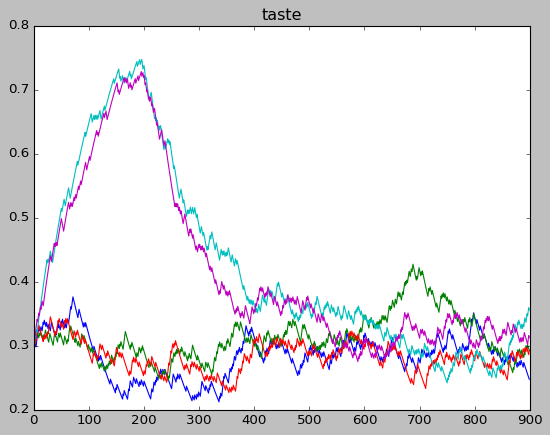

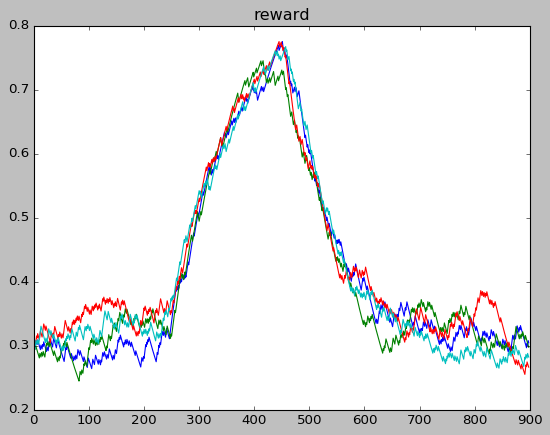

In [58]:
VISION_SIZE = 10
TASTE_SIZE = 5
REWARD_SIZE = 4

BASELINE_ACTIVATION = B = 0.3
HIGH_ACTIVATION = H = 0.8


class SpatialPattern:
  def __init__(self, values):
    self.poisson = Bernoulli(probs=values)

  def sample(self, shape):
    return self.poisson.sample(shape)

class TemporalPattern:
  def __init__(self, config):
    self.config = config
    
  def sample(self):
    all_samples = {}
    
    for modality_name, modality_config in self.config.items():
      modality_samples = torch.cat([row[2].sample([row[1] - row[0]]) for row in modality_config])
      all_samples[modality_name] = modality_samples

    return all_samples
#     for i in range(len(self.durations)):
#       all_modalities_patterns = self.spatial_patterns[i]
#       duration = self.durations[i]
      
#       samples = [torch.tensor(all_modalities_patterns[j].sample([duration])) for j in range(len(all_modalities_patterns))]
#       samples = torch.cat(samples, 1)
#       all_samples.append(samples)
      
#     return torch.cat(all_samples, 0)
    
class SensoryModality:      
  def __init__(self, name, size, baseline_activation):
    self.name = name
    self.baseline_pattern = SpatialPattern(torch.ones(size) * baseline_activation)
    
  def baseline_sample(self, shape):
    return self.baseline_pattern.sample(shape)
  
  def create_spatial_pattern(self, values):
    return SpatialPattern(torch.tensor(values))

taste = SensoryModality("taste", TASTE_SIZE, BASELINE_ACTIVATION)
reward = SensoryModality("reward", REWARD_SIZE, BASELINE_ACTIVATION)

modalities = [taste, reward]

experiment1 = TemporalPattern(
  {
    taste.name: [
      [0,   200, taste.create_spatial_pattern([B,B,B,H,H])],
      [201, 900, taste.baseline_pattern],
    ],
      
    reward.name: [
      [0,   250, reward.baseline_pattern],
      [251, 450, reward.create_spatial_pattern([H,H,H,H])],
      [451, 900, reward.baseline_pattern],
    ]
  }
)

data = experiment1.sample()
# print(data)

def trace(data, decay_rate=0.99):
  decay_rate = 0.99

  trace = torch.ones(data.shape[-1]) * B
  data_trace = [trace]

  for i in range(data.shape[0]):
    row = data[i]
    trace = trace * decay_rate + row * (1 - decay_rate)
    data_trace.append(trace)

  data_trace = torch.stack(data_trace)
  #print(data_trace)

  return data_trace

data_trace = {}
for modality in modalities:
  data_trace[modality.name] = trace(data[modality.name])
  plt.plot(data_trace[modality.name].numpy())
  plt.title(modality.name)
  plt.show()



In [65]:
class LocalEnsemble(nn.Module):
  def __init__(self, input_size, ensemble_size):
    super(LocalEnsemble, self).__init__()
    
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)

    self.input_size = input_size

    self.ensemble = nn.Linear(input_size, ensemble_size)
    self.initialize_sparse_weights(self.ensemble)
    
    self.lateral_excitatory = nn.Linear(ensemble_size, ensemble_size)
    self.initialize_sparse_weights(self.lateral_excitatory)

    self.lateral_inhibitory = nn.Linear(ensemble_size, ensemble_size)
    self.initialize_sparse_weights(self.lateral_inhibitory)


    self.previous_activation = torch.zeros(ensemble_size)
    
  def initialize_sparse_weights(self, layer):
    layer.weight.data = F.dropout(layer.weight.data, 0.5)
    self.normalize_weights(layer)    
    
  def normalize_weights(self, layer):
    layer.weight.data[layer.weight.data < 0] = 0
    print("layer.weight.data", layer.weight.data)

    den = layer.weight.data.sum(dim=1)
    den[den < 0.0001] = 1
    layer.weight.data = layer.weight.data / den[:, None]
    print("layer.weight.data2", layer.weight.data)

  def forward(self, x):
    afferent_activation = self.ensemble(x)
    lateral_excitatory_activation = torch.tanh(self.lateral_excitatory(self.previous_activation))
    lateral_inhibitory_activation = torch.tanh(self.lateral_inhibitory(self.previous_activation))
    
    activation = torch.sigmoid(afferent_activation + lateral_excitatory_activation - lateral_inhibitory_activation)
    
    self.previous_activation = activation
    return activation

modality_models = {}
for modality in modalities:
  dt = data_trace[modality.name]
  modality_models[modality.name] = model = LocalEnsemble(dt.shape[-1], 10)
  model.forward(dt) # burner
  model.forward(dt) # burner



layer.weight.data tensor([[-0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [-0.0000, 0.0000, 0.0000, 0.8304, 0.0000],
        [0.0000, -0.0000, 0.5267, 0.0000, 0.4392],
        [0.0000, 0.0000, 0.6475, 0.0000, 0.0000],
        [0.1908, -0.0000, 0.5017, 0.0000, 0.0000],
        [0.0000, 0.0000, -0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, -0.0000, 0.2841, -0.0000],
        [0.0140, 0.3032, 0.0000, 0.7227, 0.0000],
        [0.0000, 0.0000, 0.0964, 0.0000, 0.0000],
        [0.0000, -0.0000, 0.8407, 0.6540, -0.0000]])
layer.weight.data2 tensor([[-0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [-0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, -0.0000, 0.5453, 0.0000, 0.4547],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.2755, -0.0000, 0.7245, 0.0000, 0.0000],
        [0.0000, 0.0000, -0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, -0.0000, 1.0000, -0.0000],
        [0.0135, 0.2916, 0.0000, 0.6950, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.000

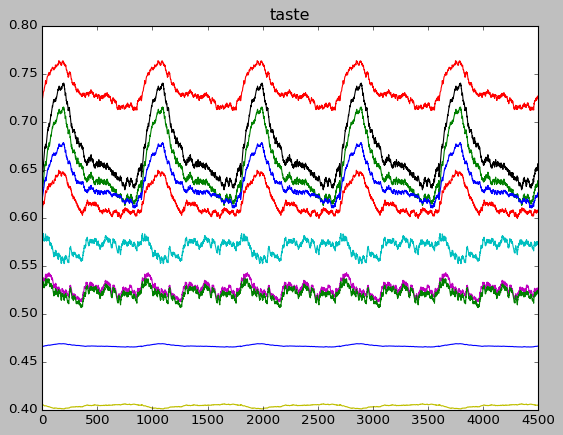

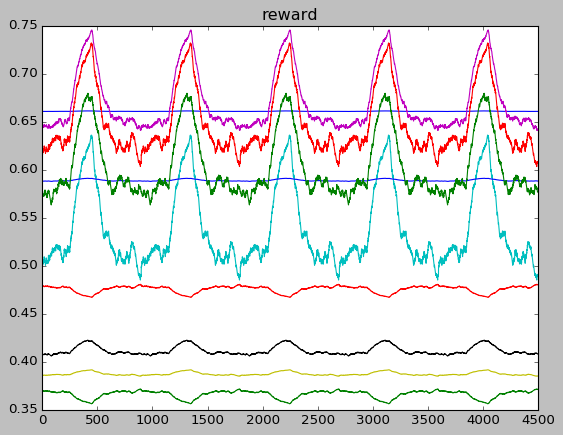

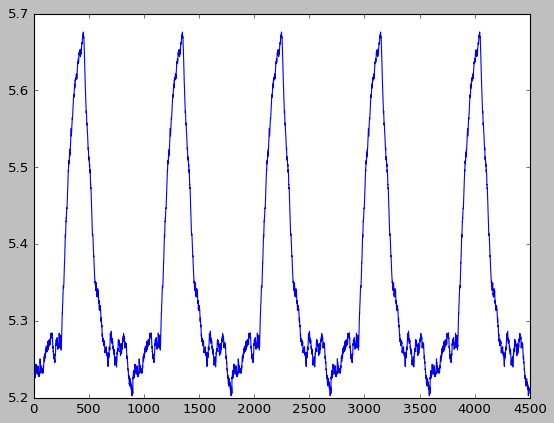

In [80]:
reward_activations = None
for modality in modalities:
  model = modality_models[modality.name]
  activations = [model.forward(data_trace[modality.name]) for _ in range(5)]
  activations = torch.stack(activations)
  # trace(activation.detach())
  activations = activations.view(-1, activations.shape[-1])
  if modality.name == 'reward':
    reward_activations = activations
  #plt.plot(trace(activations.detach()).numpy())
  plt.plot(activations.detach().numpy())
  plt.title(modality.name)
  plt.show()

total_reward_trace = reward_activations.sum(dim=1)
plt.plot(total_reward_trace.detach().numpy())
plt.show()

True